# Anorthosite xenolith ATRM data analyses

In [1]:
import pandas as pd
import numpy as np

import pmagpy.ipmag as ipmag
import pmagpy.pmag as pmag
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## First we can calculate the gamma statistic for each specimen

gamma statistic is the angular difference between the last pTRM step used for paleointensity determination and the applied field direction. 

In [2]:
AX_all_measurements = pd.read_csv('../data/IZZI/All_AX_PINT/measurements.txt', sep='\t', header=1)
AX_all_measurements = AX_all_measurements[AX_all_measurements['treat_dc_field']!=0]

AX_all_measurements_group = AX_all_measurements.groupby('specimen').apply(lambda x: x.iloc[x['sequence'].argmax()])
AX_all_measurements_group = AX_all_measurements_group.reset_index(drop=True)

In [3]:
# now let's compare the angle between the last measurement with inc=-90 which is the applied field direction

AX_all_measurements_group['gamma'] = np.abs(AX_all_measurements_group['dir_inc']+90)

In [4]:
AX_all_measurements_group[['specimen', 'gamma']]

,specimen,gamma
0,AX1-1a,1.4
1,AX1-2a,1.0
2,AX1-3a,1.5
3,AX1-4a,2.3
4,AX1-5a,0.6
...,...,...
81,AX7-3a,2.6
82,AX8-1a,7.0
83,AX8-2a,3.7
84,AX8-3a,11.2


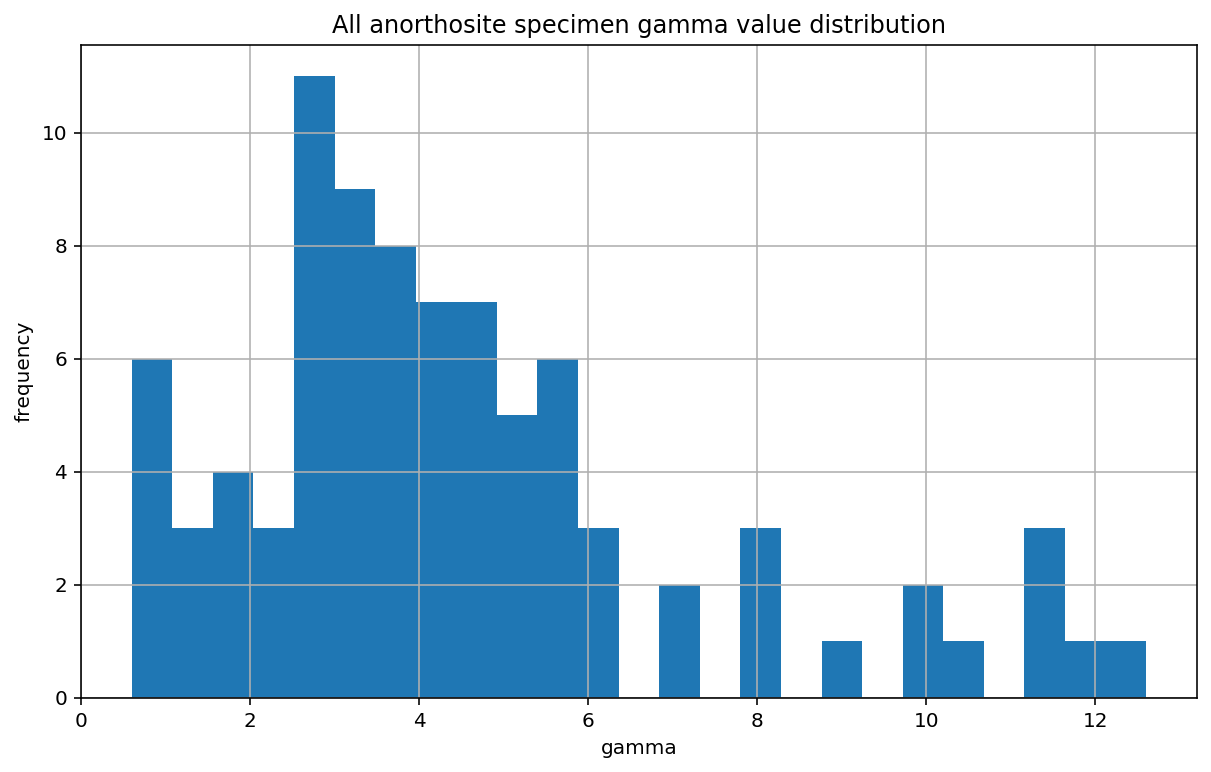

In [5]:
plt.figure(figsize= (10, 6))
AX_all_measurements_group['gamma'].hist(bins=25)

plt.xlabel('gamma')
plt.ylabel('frequency')

plt.title('All anorthosite specimen gamma value distribution')
plt.show()

In [6]:
success_AX_measurements_group = AX_all_measurements_group[AX_all_measurements_group['specimen'].str.contains('AX6|AX8|AX10|AX11|AX12|AX13|AX16')]
success_AX_measurements_group = success_AX_measurements_group.reset_index(drop=True)

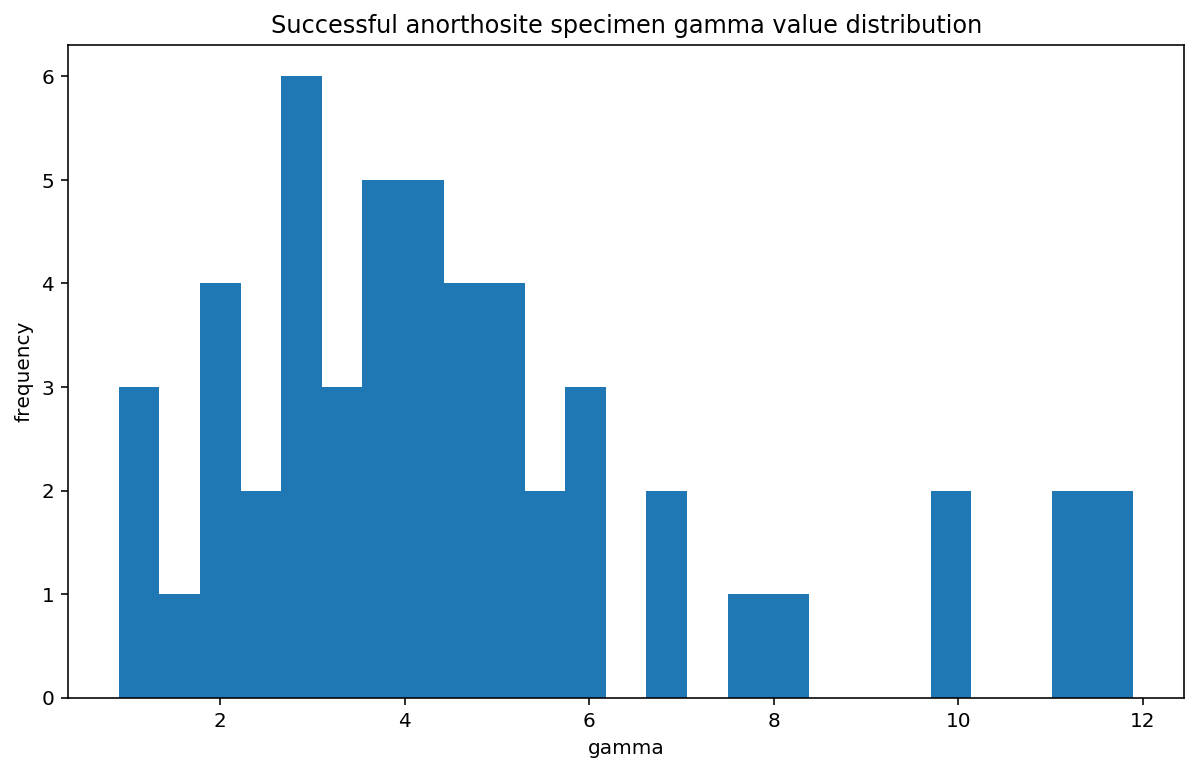

In [7]:
plt.figure(figsize= (10, 6))
success_AX_measurements_group['gamma'].hist(bins=25, grid=0)

plt.xlabel('gamma')
plt.ylabel('frequency')

plt.title('Successful anorthosite specimen gamma value distribution')
plt.show()

In [8]:
success_AX_measurements_group['gamma'].median()

4.149999999999999

In [9]:
success_AX_measurements_group['gamma'].min()

0.9000000000000057

In [10]:
success_AX_measurements_group['gamma'].max()

11.900000000000006

## defining functions for reading magnetometer files and making plots

In [11]:
# get specimen list from sam file
def get_specimen_list(SAM_file_path):
    this_file = open(SAM_file_path, 'r')
    lines = this_file.readlines()
    specimen_list = list()
    for i in range (2, len(lines)):
        thisline = lines[i].split('\n')
        specimen_list.append(thisline[0])
    return specimen_list

def plot_ATRM(angle_list, moment_list, spec_name = '', savefig = False):
    moment_list = [i/max(moment_list) for i in moment_list] # normalize the moment list
    
    plt.plot(angle_list, moment_list, '.-')
    plt.xlabel('Angle of applied field ($^\circ$)')
    plt.ylabel('Normalized Full TRM')
    
    plt.title(spec_name + ' ATRM plot')
    if savefig == True:
        plt.savefig(spec_name + ' ATRM_plot.pdf')
    plt.show()

def plot_TRM_nonlinear(field_list, moment_list, spec_name = '', savefig = False):
    moment_list = [i/max(moment_list) for i in moment_list] # normalize the moment list
    plt.plot(field_list, moment_list, '.-')
    plt.xlabel('Strenth of applied lab field ($\mu$T)')
    plt.ylabel('Normalized Full TRM')
    plt.plot([min(field_list), max(field_list)],[min(field_list)/max(field_list), max(moment_list)], '--', color = 'grey')
    plt.title(spec_name + ' TRM acquisition plot')
    if savefig == True:
        plt.savefig(spec_name + ' TRM_nonlinear_plot.pdf')
    plt.show()

## TRM non-linear test

We also performed full TRM acquisition experiment at different lab fields. the choses fields are; [30, 50, 70, 90] $\mu$T. The TRM is imparted along specimen Z axis. 
The results turns out to be quite nice: that at least in this site, we do not have a significant non-linear behavior in the specimens, at least for lab fields lower than 90 micro tesla. 

In [12]:
angle_list = [0, 45, 90, 135, 180, 225, 270, 315]

In [13]:
field_list = [30, 50, 70, 90] # unit in uT

In [14]:
specimen_list = get_specimen_list('../Data/Rock_mag/AX_ATRM/AX_ATRM.sam')

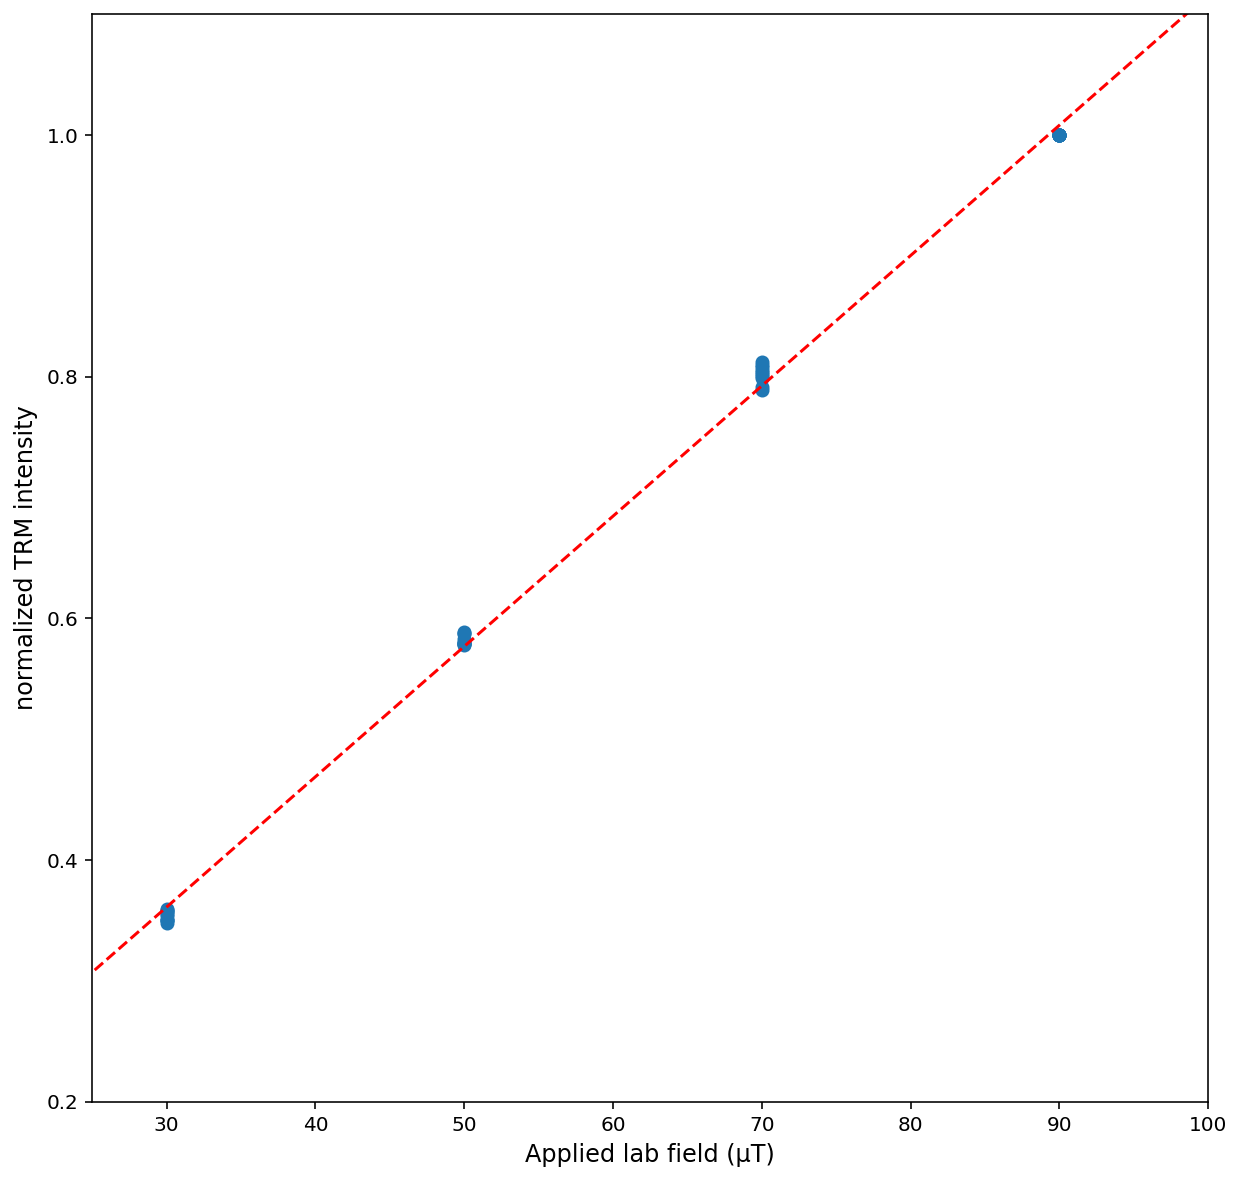

In [40]:
plt.figure(figsize=(10,10))
all_moments = []
all_fields = []
for i in range(len(specimen_list)):
    this_file = open('../Data/Rock_mag/AX_ATRM/' + specimen_list[i], 'r')
    lines = this_file.readlines()
    for j in range(2, len(lines)):
        lines[j] = lines[j][7:]
    data_lines = lines[2:]

    moment_list = list()
    geo_dec = list()
    geo_inc = list()
    spec_dec = list()
    spec_inc = list()
    
    nl_moment_list = list()
    nl_geo_dec = list()
    nl_geo_inc = list()
    nl_spec_dec = list()
    nl_spec_inc = list()
    
    xy_component = list()
    
    # here we are getting the nnonlinear TRM data
    for n in range(8, len(data_lines)):
        nl_geo_dec.append(float(data_lines[n][0:5]))
        nl_geo_inc.append(float(data_lines[n][6:11]))
        nl_moment_list.append(float(data_lines[n][24:32]))
        
        
        nl_spec_dec.append(float(data_lines[n][39:44]))
        nl_spec_inc.append(float(data_lines[n][46:50]))
    all_fields = all_fields + field_list 
    moment_list = [i/max(nl_moment_list) for i in nl_moment_list]
    all_moments = all_moments + moment_list
    plt.scatter(field_list, moment_list, color = 'C0')
    
linear_fit = np.polyfit(all_fields, all_moments, deg=1, )
x = np.linspace(0, 100)
y = x*linear_fit[0] + linear_fit[1]

plt.plot(x, y, ls='--', c='r', label = 'linear fit through data')
plt.xlabel('Applied lab field (µT)', fontsize=12)
plt.ylabel('normalized TRM intensity', fontsize=12)
plt.ylim(0.2, 1.1)
plt.xlim(25, 100)
plt.savefig('code_output/ATRM_test.pdf', bbox_inches='tight')
plt.show()
